# **Plasmodium Vivax (malaria) parasite detector and counter**

## **1.0 Introduction**

## **1.1 Problem Statement**

## **1.2 Objectives**

1. To detect Plasmodium Vivax (malaria parasite) in human cells
2. To count the number of detected plasmodium vivax parasites per image

## **1.4 Installing & Importing Required Libraries**

In [ ]:
!pip install Pillow #installing PILLOW LIBRARY

In [ ]:
!pip install matplotlib

In [ ]:
import os #
import json # 
import random
from pprint import pprint #
import PIL
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import Counter

## **1.5 Loading & Understanding Malaria Dataset structure**

Dataset courced from: https://bbbc.broadinstitute.org/BBBC041/

The dataset consists of:
- image folder
- training json file
- test json file

In [4]:
# Check current directory
print("Current directory:", os.getcwd())

# List files and folders
print("Contents here:", os.listdir())

# If you see 'images', list inside it
if 'images' in os.listdir():
    print("Example image files:", os.listdir('images')[:10])

Current directory: /Users/h.nderitu/Documents/Data Science Material/Capstone Project/data_science_capstone_project
Contents here: ['.DS_Store', 'malaria_parasite_detection_count.ipynb', 'malaria', 'README.md', '.gitignore', '.git']


In [5]:
# Look inside the malaria folder
print("Contents of malaria/:", os.listdir("malaria"))

Contents of malaria/: ['.DS_Store', 'training.json', 'images', 'test.json']


In [30]:
# List all files ending in common image extensions
# Path to your images
image_folder = "malaria/images"

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Print results
print(f"Number of images in '{image_folder}': {len(image_files)}")
print("Example files:", image_files[:5])

Number of images in 'malaria/images': 1328
Example files: ['027ab174-e47a-44f8-b85b-372449eeb7d8.png', 'b1145408-feae-4637-b4cf-3e70b99cc62d.png', '351d6536-3a5c-46eb-a6e4-d71dd999908a.jpg', 'a11ed7d0-12f6-468f-abad-5cba7d968123.png', '415409ac-97b3-4cd9-b203-11ef00662352.png']


In [53]:
# Load training JSON file
with open("malaria/training.json") as f: 
    train_data = json.load(f)

In [57]:
# check every image listed in training.json actually exists in images folder
train_json_images = [os.path.basename(item["image"]["pathname"]) for item in train_data]
missing = [img for img in train_json_images if img not in image_files]

print(f"train JSON images: {len(train_json_images)}")
print(f"Found in image folder: {len(image_files)}")
print(f"Missing images: {len(missing)}")

if missing:
    print("Missing examples:", missing[:5])


train JSON images: 1208
Found in image folder: 1328
Missing images: 0


In [58]:
# Collect all category names from all images
all_categories = []

for item in train_data:
    for obj in item["objects"]:
        cat = obj["category"].lower().strip()
        all_categories.append(cat)

# Count occurrences
category_counts = Counter(all_categories)

# Display summary
print("📊 Category Summary (All objects):\n")
for cat, count in category_counts.items():
    print(f"{cat.title():<25}: {count}")

# Optionally, show total objects
total = sum(category_counts.values())
print(f"\nTotal objects (all categories): {total}")

📊 Category Summary (All objects):

Red Blood Cell           : 77420
Trophozoite              : 1473
Schizont                 : 179
Difficult                : 441
Ring                     : 353
Leukocyte                : 103
Gametocyte               : 144

Total objects (all categories): 80113


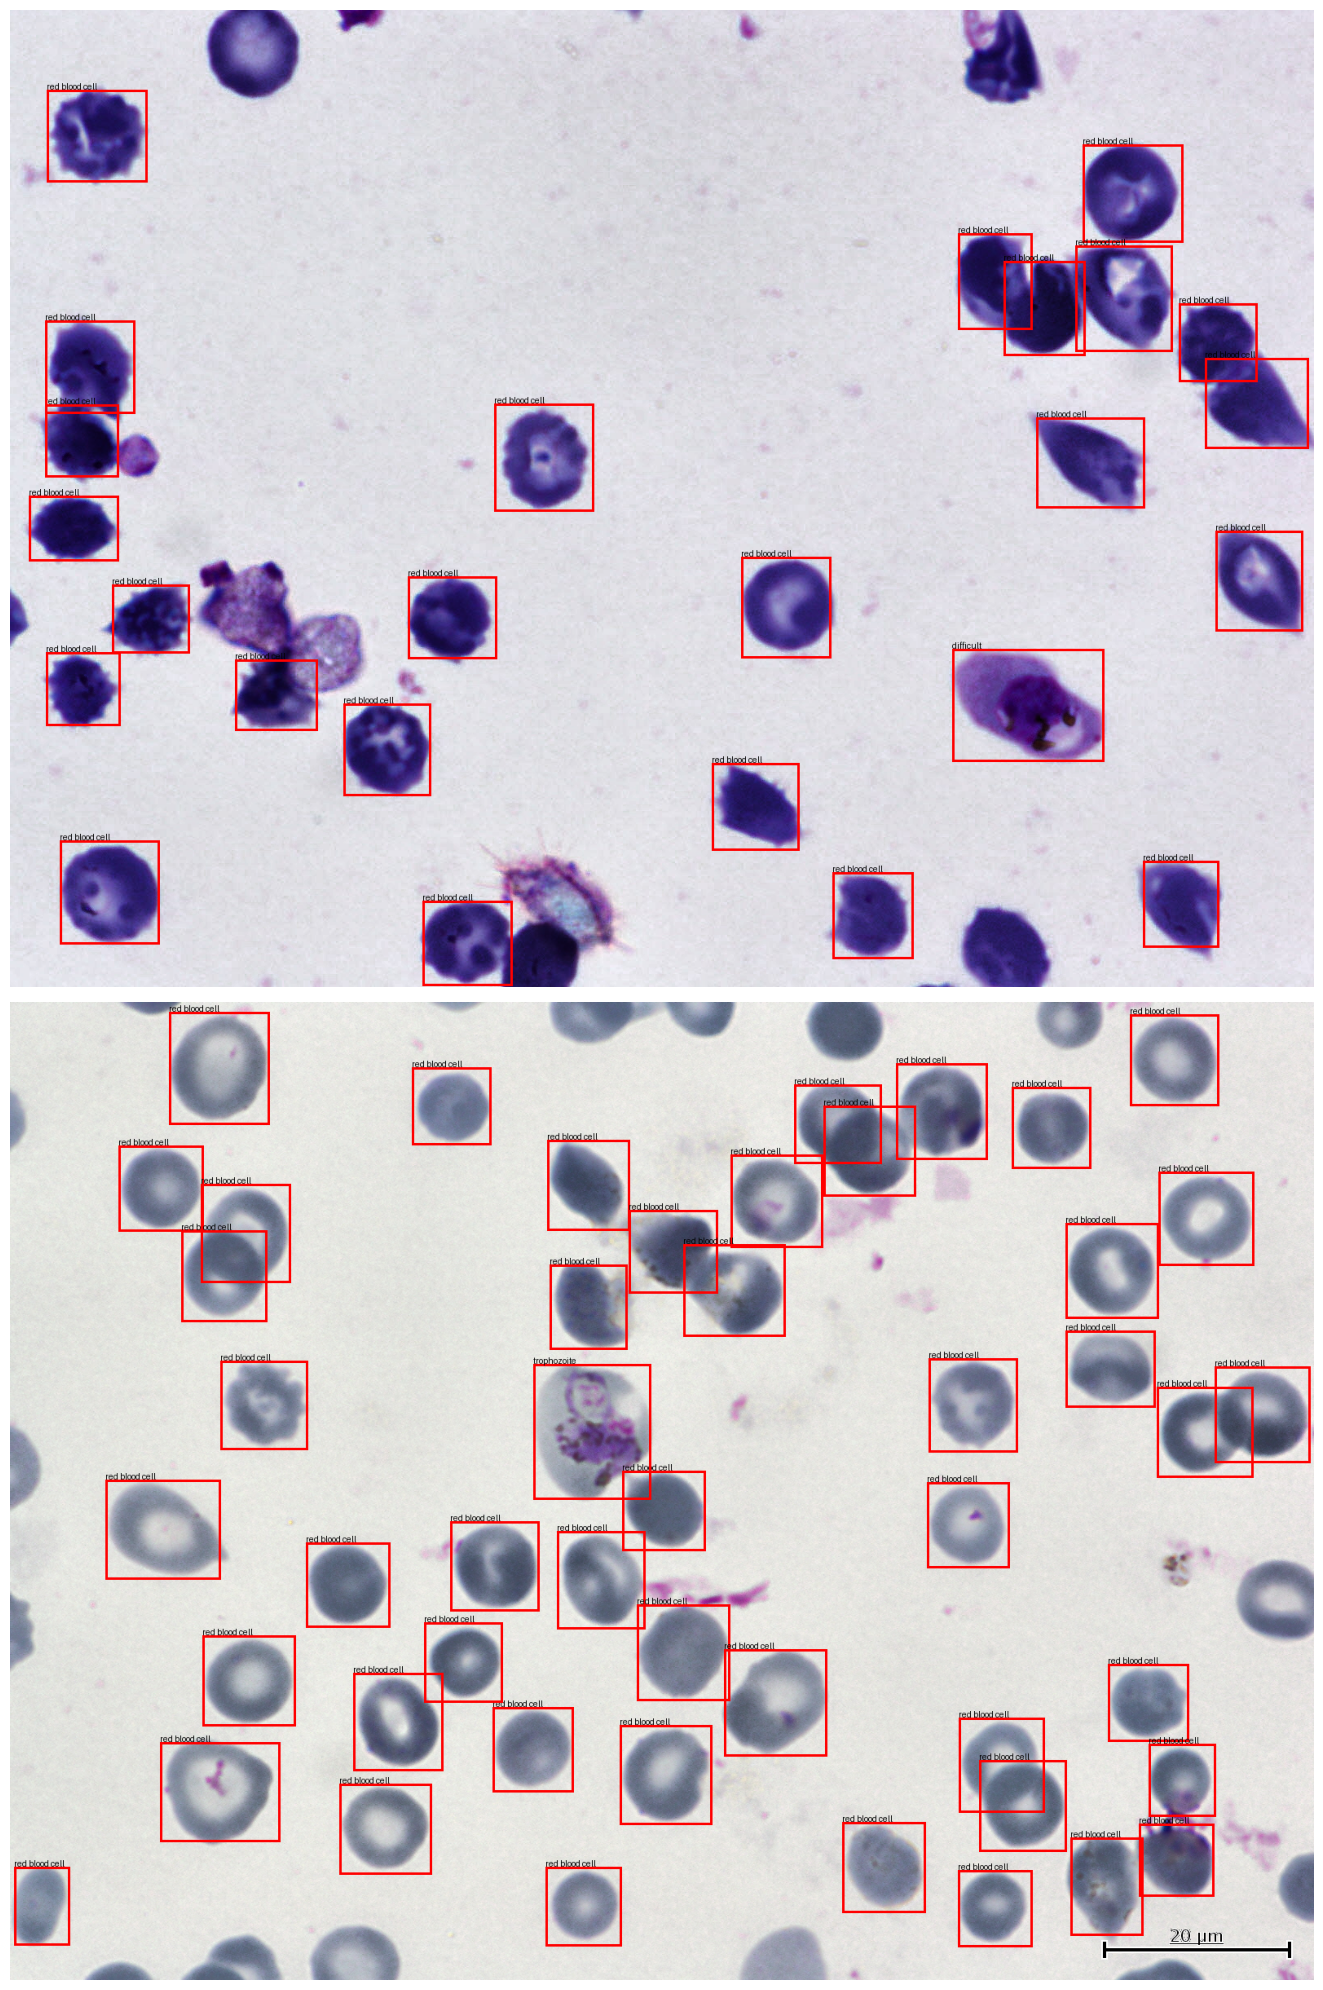

In [59]:
# view 2 images with the annotations and categories
# Load JSON
with open("malaria/training.json") as f:
    train_data = json.load(f)
if isinstance(train_data[0], list):
    train_data = train_data[0]  # unwrap

# Randomly sample 10 images
samples = random.sample(train_data,2)

# Try loading a font (fallback to default)
try:
    font = ImageFont.truetype("arial.ttf", 30)
except:
    font = ImageFont.load_default()

plt.figure(figsize=(20, 20))

for idx, sample in enumerate(samples):
    img_path = os.path.join("malaria/images", os.path.basename(sample["image"]["pathname"]))
    img = Image.open(img_path).convert("RGB")

    draw = ImageDraw.Draw(img)
    for obj in sample["objects"]:
        box = obj["bounding_box"]
        xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
        xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
        category = obj["category"]
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        draw.text((xmin, ymin - 10), category, fill="black", font=font)

    plt.subplot(2, 1, idx + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


## 1.6 Data Cleaning

In [60]:
# Check for corrupted images & remove
# Open each image and skip unreadable files
image_folder = "malaria/images"

for fname in os.listdir(image_folder):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        try:
            img = Image.open(os.path.join(image_folder, fname))
            img.verify()  # checks for corruption
        except Exception as e:
            print("Corrupt image removed:", fname)
            os.remove(os.path.join(image_folder, fname))

In [61]:
# check duplicate images
import hashlib
from collections import defaultdict

# Helper function to compute hash
def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Compute hashes for all images
hash_dict = defaultdict(list)
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        h = file_hash(path)
        hash_dict[h].append(filename)

# Report duplicates
duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates)} groups of duplicate images.")
for h, files in list(duplicates.items())[:5]:  # show first 5 examples
    print("→", files)


Found 0 groups of duplicate images.


In [44]:
!pip install imagehash Pillow

  Obtaining dependency information for imagehash from https://files.pythonhosted.org/packages/31/2c/5f0903a53a62029875aaa3884c38070cc388248a2c1b9aa935632669e5a7/ImageHash-4.3.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for PyWavelets from https://files.pythonhosted.org/packages/b5/f3/0fa57b6407ea9c4452b0bc182141256b9481b479ffbfc9d7fdb73afe193b/pywavelets-1.9.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/80/d1/eed51ab64d227fe60229a2d57fb60ca5898cfa50ba27d4f573e9e5f0b430/scipy-1.16.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 192.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 587.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.8 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 3.4 MB/s eta 0:00:0000:0100:01



In [62]:
import imagehash # find visually identical images

hash_dict = defaultdict(list)

for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(image_folder, filename)
        img = Image.open(path)
        h = str(imagehash.phash(img))  # perceptual hash
        hash_dict[h].append(filename)

duplicates = {h: files for h, files in hash_dict.items() if len(files) > 1}

print(f"Found {len(duplicates)} visually duplicate groups.")
for h, files in list(duplicates.items())[:5]:
    print("→", files)

Found 1 visually duplicate groups.
→ ['f329e01b-fbd3-4fb5-9738-a7ff4c8622b8.png', '3061aac0-cda3-47d1-8c48-6293e9ffdf36.png']


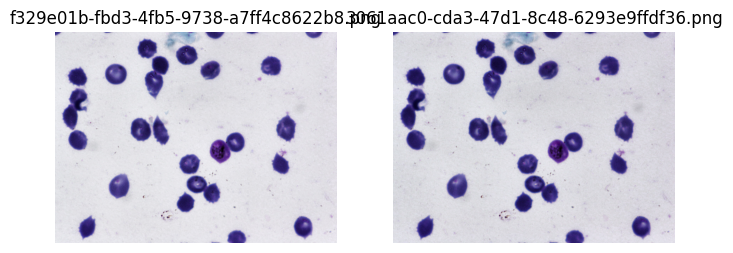

In [63]:
# Show the first two duplicates side by side
imgs = [Image.open(os.path.join(image_folder, f)) for f in files[:2]]
plt.figure(figsize=(8,4))
for i, img in enumerate(imgs):
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(files[i])
    plt.axis("off")
plt.show()

🔢 Class counts and percentages:
red blood cell: 77420 (96.64%)
trophozoite: 1473 (1.84%)
schizont: 179 (0.22%)
difficult: 441 (0.55%)
ring: 353 (0.44%)
leukocyte: 103 (0.13%)
gametocyte: 144 (0.18%)


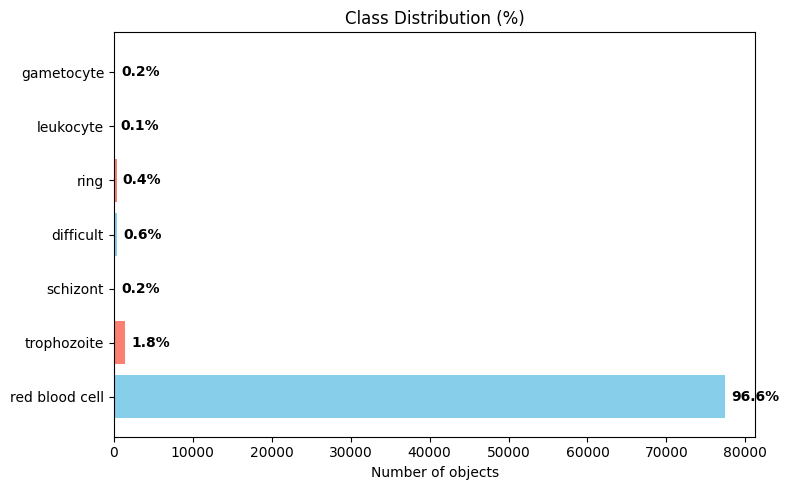

In [67]:
 # check class imbalance
# Count all object categories, summarize all object categories in the training.json file
# --- Count categories ---
categories = []
for item in train_data:
    for obj in item["objects"]:
        categories.append(obj["category"])

# --- Compute counts and percentages ---
counts = Counter(categories)
total = sum(counts.values())
percentages = {cls: (count / total) * 100 for cls, count in counts.items()}

# --- Print class distribution ---
print("🔢 Class counts and percentages:")
for cls, count in counts.items():
    print(f"{cls}: {count} ({percentages[cls]:.2f}%)")

# --- Plot horizontal bar chart ---
plt.figure(figsize=(8, 5))
classes = list(counts.keys())
values = list(counts.values())
percents = [percentages[c] for c in classes]

bars = plt.barh(classes, values, color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Class Distribution (%)")
plt.xlabel("Number of objects")

# --- Add percentage labels next to bars ---
for bar, pct in zip(bars, percents):
    width = bar.get_width()
    plt.text(width + max(values)*0.01, bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

There are class imbalances. The proportion of uninfected red blood cells is highest. 

In [ ]:
# remove mislabelled mages

## 1.7 Image preprocessing

Not necessary for YOLO as the augmentations are built in. automatically applied when augment = true during training

In [ ]:
# Resizing
# have fixed size inputs. Use standdard size e.g. 640 * 640
# Not necessary for YOLO MODEL, handled automatically. 

In [ ]:
# Normalize pixel values 
# helps models train faster & converge better divide by 255, scale pixels from 0,255 to 0,1
# Not necessary for YOLO MODEL, handled automatically. 

In [ ]:
# Ensure consistent colour channels

In [ ]:
# align bounding boxes
# # Not necessary for YOLO MODEL, handled automatically. 

## 1.8 Data Augmentation

to increase dataset diversity, prevent overfitting, and make model robust to variations like lighting, rotation, and cell density.

Many are not necessary for YOLO as the augmentations are built in. automatically applied when augment = true during training

- Random flips - horizontal/vertical flips
- Random rotations
- Brightness/contrast shift
- Gaussian noise/blur
- Scaling/zooming
- Colour/jitter
- Cutout/mosaic - do for YOLO MODEL, combines multiple images

In [ ]:
# CODE FOR PREPROCESSING for non YOLO models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=[0.8, 1.2],
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True
# )

Counting-specific preprocessing

For counting models (regression or density estimation):

Normalize cell size by using consistent magnification or image size.

Optionally apply a background normalization (subtract local mean intensity).

For density maps: use Gaussian kernels centered at each cell location.

## YOLO MODEL

In [ ]:
# FOR YOLOv8 - augmentations. YOLOv8 includes augmentations such as: HSV color shifts, Random scaling, Random perspective, Mosaic & mixup, Flips and rotations

# yolo detect train data=malaria.yaml model=yolov8n.pt epochs=100 imgsz=640 augment=True